In [1]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np

# Load your dataset
df = pd.read_csv('/kaggle/input/resume-dataset/Resume/Resume.csv')
df.head()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [2]:
labels = []

In [3]:
category_list = df['Category'].value_counts().keys()
category_label = {}
i=0
for category in category_list:
    category_label[category] = i
    i += 1
for label in df["Category"]:
    labels.append(label)
    

final_label = []

for label in labels:
    final_label.append(category_label[label])


In [10]:
category_label

{'INFORMATION-TECHNOLOGY': 0,
 'BUSINESS-DEVELOPMENT': 1,
 'FINANCE': 2,
 'ADVOCATE': 3,
 'ACCOUNTANT': 4,
 'ENGINEERING': 5,
 'CHEF': 6,
 'AVIATION': 7,
 'FITNESS': 8,
 'SALES': 9,
 'BANKING': 10,
 'HEALTHCARE': 11,
 'CONSULTANT': 12,
 'CONSTRUCTION': 13,
 'PUBLIC-RELATIONS': 14,
 'HR': 15,
 'DESIGNER': 16,
 'ARTS': 17,
 'TEACHER': 18,
 'APPAREL': 19,
 'DIGITAL-MEDIA': 20,
 'AGRICULTURE': 21,
 'AUTOMOBILE': 22,
 'BPO': 23}

In [4]:
df['text'] = df['Resume_str']
df['label'] = final_label

In [5]:
df.head()

,ID,Resume_str,Resume_html,Category,text,label
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,15
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR,"HR SPECIALIST, US HR OPERATIONS ...",15
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR,HR DIRECTOR Summary Over 2...,15
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR,HR SPECIALIST Summary Dedica...,15
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR,HR MANAGER Skill Highlights ...,15


In [6]:
texts = df["text"].tolist()
labels = df["label"].tolist()

In [7]:


# Split your dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Tokenization
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# Tokenization
def tokenize_function(texts, labels):
    encodings = tokenizer(texts, padding="max_length", truncation=True, max_length=512)
    encodings["labels"] = labels
    return encodings

train_encodings = tokenize_function(X_train, y_train)
test_encodings = tokenize_function(X_test, y_test)

# Convert to datasets format
from datasets import Dataset
train_dataset = Dataset.from_dict({k: v for k, v in train_encodings.items()})
test_dataset = Dataset.from_dict({k: v for k, v in test_encodings.items()})
train_dataset = train_dataset.with_format("torch")
test_dataset = test_dataset.with_format("torch")


In [8]:
# Model Initialization
num_labels = len(set(labels))
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=num_labels)

# Metrics
from datasets import load_metric
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# Training
training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initi

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.064942,0.418511
2,No log,1.194846,0.718310
3,2.225700,1.008347,0.766600


TrainOutput(global_step=747, training_loss=1.8115423322521857, metrics={'train_runtime': 402.0497, 'train_samples_per_second': 14.827, 'train_steps_per_second': 1.858, 'total_flos': 1568714806665216.0, 'train_loss': 1.8115423322521857, 'epoch': 3.0})

# Increase the accuracy

In [20]:
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from datasets import Dataset

# Extracting texts and labels from the dataframe
texts = df["text"].tolist()
labels = df["label"].tolist()

# Splitting the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Initializing the tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# Tokenization
def tokenize_function(texts, labels):
    encodings = tokenizer(texts, padding="max_length", truncation=True, max_length=512)
    encodings["labels"] = labels
    return encodings

train_encodings = tokenize_function(X_train, y_train)
test_encodings = tokenize_function(X_test, y_test)

# Convert to datasets format
from datasets import Dataset
train_dataset = Dataset.from_dict({k: v for k, v in train_encodings.items()})
test_dataset = Dataset.from_dict({k: v for k, v in test_encodings.items()})
train_dataset = train_dataset.with_format("torch")
test_dataset = test_dataset.with_format("torch")


In [ ]:
!rm -r /kaggle/working/results
!rm -r /kaggle/working/logs

In [11]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np

# 1. Initializing the model
num_labels = len(set(labels))  # Assuming labels are integers starting from 0
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=num_labels)

# 2. Setting up the training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

# 3. Defining the evaluation metric
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": (predictions == labels).mean()}

# 4. Initializing the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# 5. Training the model
trainer.train()


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initi

Epoch,Training Loss,Validation Loss,Accuracy
1,2.189900,1.983532,0.557344
2,1.014600,1.012277,0.810865
3,1.052800,0.802220,0.816901
4,0.630300,0.719321,0.824950
5,0.513700,0.686173,0.835010


TrainOutput(global_step=1245, training_loss=1.2791890025617607, metrics={'train_runtime': 585.5196, 'train_samples_per_second': 16.968, 'train_steps_per_second': 2.126, 'total_flos': 2614524677775360.0, 'train_loss': 1.2791890025617607, 'epoch': 5.0})

In [ ]:
category_label

In [12]:
# Save the model
trainer.save_model("./saved_model_bert_resume")

# Save the tokenizer
tokenizer.save_pretrained("./saved_model_bert_resume")

('./saved_model_bert_resume/tokenizer_config.json',
 './saved_model_bert_resume/special_tokens_map.json',
 './saved_model_bert_resume/vocab.txt',
 './saved_model_bert_resume/added_tokens.json',
 './saved_model_bert_resume/tokenizer.json')

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("./saved_model_bert_resume")
tokenizer = AutoTokenizer.from_pretrained("./saved_model_bert_resume")

In [7]:
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from datasets import Dataset

# Extracting texts and labels from the dataframe
texts = df["text"].tolist()
labels = df["label"].tolist()

# Splitting the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Initializing the tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# Tokenization
def tokenize_function(texts, labels):
    encodings = tokenizer(texts, padding="max_length", truncation=True, max_length=512)
    encodings["labels"] = labels
    return encodings

train_encodings = tokenize_function(X_train, y_train)
test_encodings = tokenize_function(X_test, y_test)

# Convert to datasets format
from datasets import Dataset
train_dataset = Dataset.from_dict({k: v for k, v in train_encodings.items()})
test_dataset = Dataset.from_dict({k: v for k, v in test_encodings.items()})
train_dataset = train_dataset.with_format("torch")
test_dataset = test_dataset.with_format("torch")


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initi

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.987600,1.682478,0.639839,0.609023,0.639839,0.590501
2,1.020200,1.011710,0.794769,0.792600,0.794769,0.784293
3,1.055500,0.794081,0.824950,0.825383,0.824950,0.815184
4,0.574600,0.716119,0.826962,0.814355,0.826962,0.816896
5,0.583300,0.698681,0.830986,0.816822,0.830986,0.819197


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

TrainOutput(global_step=1245, training_loss=1.1992342535271703, metrics={'train_runtime': 591.2441, 'train_samples_per_second': 16.804, 'train_steps_per_second': 2.106, 'total_flos': 2614524677775360.0, 'train_loss': 1.1992342535271703, 'epoch': 5.0})

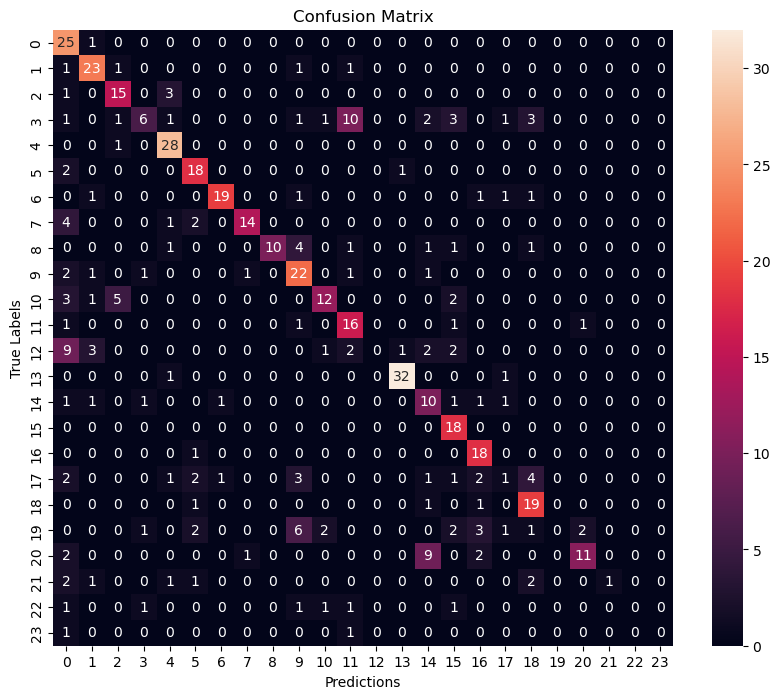

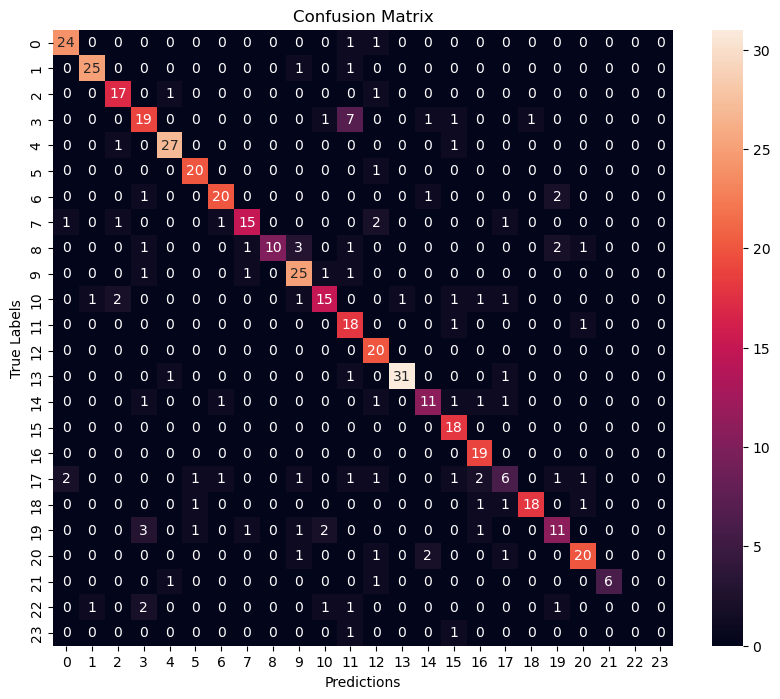

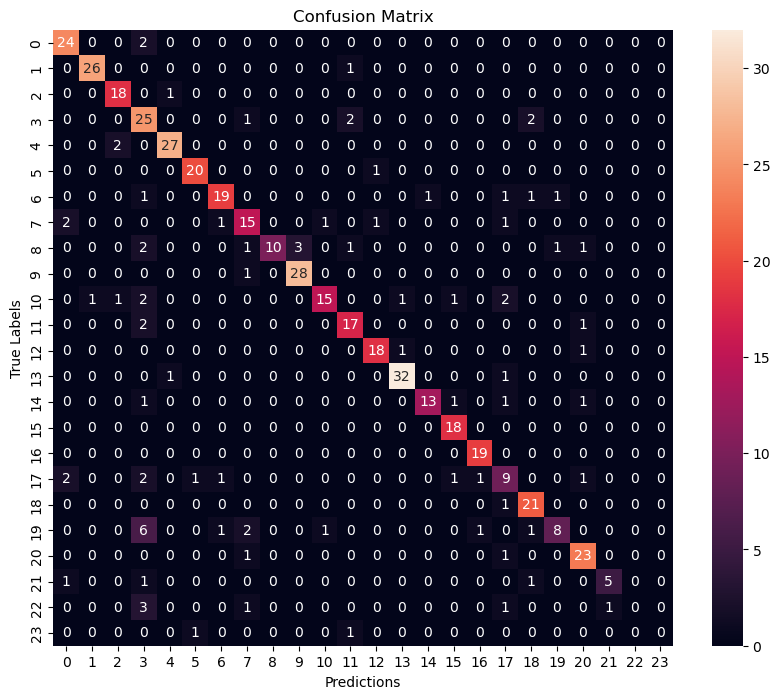

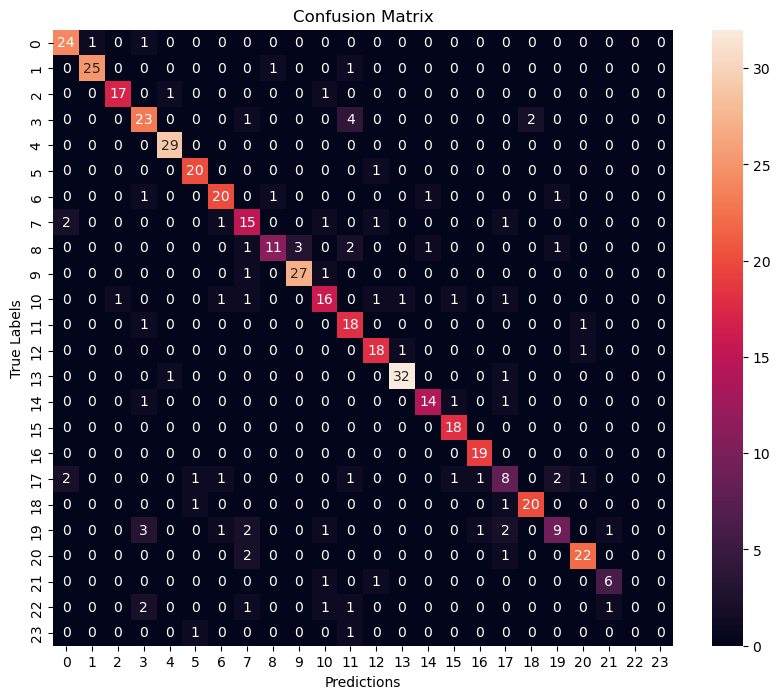

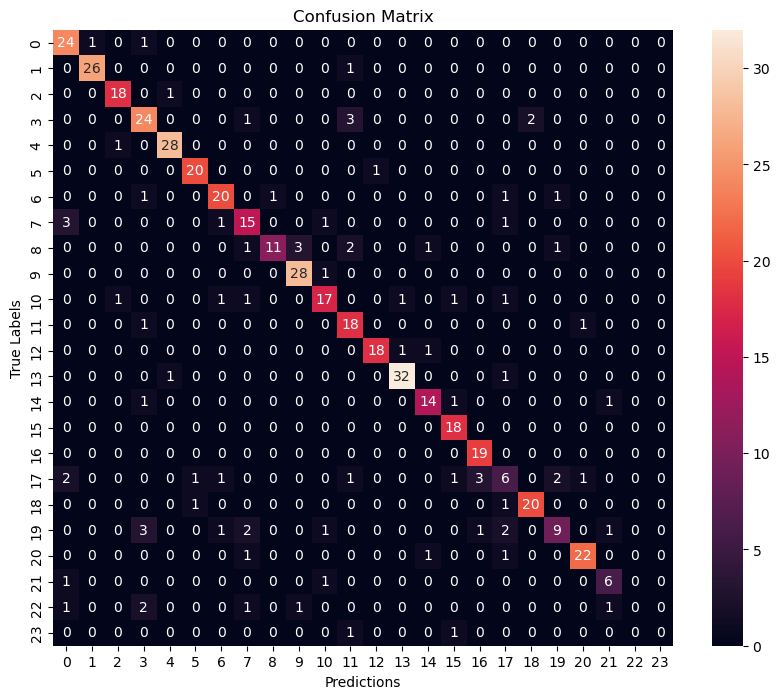

In [9]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Initializing the model
num_labels = len(set(labels))  # Assuming labels are integers starting from 0
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=num_labels)

# 2. Setting up the training arguments
training_args = TrainingArguments(
    output_dir="./results1",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir='./logs1',
    logging_steps=10,
)

# 3. Defining the evaluation metric
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    
    # Save confusion matrix
    conf_mat = confusion_matrix(labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_mat, annot=True, fmt='g')
    plt.xlabel('Predictions')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.savefig('./results1/confusion_matrix.png')
    
    # You can add more visualizations if needed
    
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

# 4. Initializing the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# 5. Training the model
trainer.train()


# Use SamLowe/roberta-base-go_emotions

In [41]:
df.head()

,ID,Resume_str,Resume_html,Category,text,label
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,15
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR,"HR SPECIALIST, US HR OPERATIONS ...",15
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR,HR DIRECTOR Summary Over 2...,15
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR,HR SPECIALIST Summary Dedica...,15
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR,HR MANAGER Skill Highlights ...,15


In [43]:
df.to_csv('/kaggle/working/data.csv',index=False)

In [47]:
df = pd.read_csv('/kaggle/working/data.csv')
df.head()

,ID,Resume_str,Resume_html,Category,text,label
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,15
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR,"HR SPECIALIST, US HR OPERATIONS ...",15
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR,HR DIRECTOR Summary Over 2...,15
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR,HR SPECIALIST Summary Dedica...,15
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR,HR MANAGER Skill Highlights ...,15


In [51]:
import torch
from sklearn.model_selection import train_test_split
from datasets import load_dataset, Dataset
from transformers import (
    RobertaTokenizerFast,
    RobertaForSequenceClassification,
    TrainingArguments,
    Trainer,
    RobertaConfig,
)

# Assuming your dataset is loaded into a variable called 'df'
# and it has two columns: 'text' and 'label'
dataset = load_dataset('csv', data_files={'data': '/kaggle/working/data.csv'})

# Splitting the dataset into train and test
texts = dataset['data']['text']
labels = dataset['data']['label']
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

train_dataset = Dataset.from_dict({'text': X_train, 'label': y_train})
test_dataset = Dataset.from_dict({'text': X_test, 'label': y_test})

# Preprocessing
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, max_length=256)

train_dataset = train_dataset.map(tokenize, batched=True, batch_size=len(train_dataset))
test_dataset = test_dataset.map(tokenize, batched=True, batch_size=len(test_dataset))

train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Convert labels to strings for id2label and label2id mappings
str_labels = [str(label) for label in train_dataset["label"]]
class_names = sorted(set(str_labels))
num_labels = len(class_names)
id2label = {i: label for i, label in enumerate(class_names)}
label2id = {label: i for i, label in enumerate(class_names)}

config = RobertaConfig.from_pretrained("roberta-base", num_labels=num_labels, id2label=id2label, label2id=label2id)
model = RobertaForSequenceClassification.from_pretrained("roberta-base", config=config)

# TrainingArguments
training_args = TrainingArguments(
    output_dir="./results_roberta",
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    logging_dir="./logs_roberta",
    logging_strategy="steps",
    logging_steps=10,
    learning_rate=5e-5,
    weight_decay=0.01,
    warmup_steps=500,
    save_strategy="epoch",
    load_best_model_at_end=True,
    save_total_limit=2,
    report_to="tensorboard",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

trainer.train()

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should pr

Epoch,Training Loss,Validation Loss
1,2.426100,1.958620
2,1.000700,1.095004
3,1.151100,0.772014
4,0.738300,0.799608
5,0.508900,0.762340


TrainOutput(global_step=1245, training_loss=1.312864256479654, metrics={'train_runtime': 305.5233, 'train_samples_per_second': 32.518, 'train_steps_per_second': 4.075, 'total_flos': 1307262338887680.0, 'train_loss': 1.312864256479654, 'epoch': 5.0})

In [52]:
# Save the model
trainer.save_model("./saved_model_roberta_resume")

# Save the tokenizer
tokenizer.save_pretrained("./saved_model_roberta_resume")

('./saved_model_roberta_resume/tokenizer_config.json',
 './saved_model_roberta_resume/special_tokens_map.json',
 './saved_model_roberta_resume/vocab.json',
 './saved_model_roberta_resume/merges.txt',
 './saved_model_roberta_resume/added_tokens.json',
 './saved_model_roberta_resume/tokenizer.json')

In [ ]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from datasets import load_dataset, Dataset
from transformers import (
    RobertaTokenizerFast,
    RobertaForSequenceClassification,
    TrainingArguments,
    Trainer,
    RobertaConfig,
)

# Assuming your dataset is loaded into a variable called 'df'
# and it has two columns: 'text' and 'label'
dataset = load_dataset('csv', data_files={'data': '/kaggle/working/data.csv'})

# Splitting the dataset into train and test
texts = dataset['data']['text']
labels = dataset['data']['label']
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

train_dataset = Dataset.from_dict({'text': X_train, 'label': y_train})
test_dataset = Dataset.from_dict({'text': X_test, 'label': y_test})

# Preprocessing
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, max_length=256)

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {"accuracy": accuracy_score(p.label_ids, preds)}

train_dataset = train_dataset.map(tokenize, batched=True, batch_size=len(train_dataset))
test_dataset = test_dataset.map(tokenize, batched=True, batch_size=len(test_dataset))

train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Convert labels to strings for id2label and label2id mappings
str_labels = [str(label) for label in train_dataset["label"]]
class_names = sorted(set(str_labels))
num_labels = len(class_names)
id2label = {i: label for i, label in enumerate(class_names)}
label2id = {label: i for i, label in enumerate(class_names)}

config = RobertaConfig.from_pretrained("roberta-base", num_labels=num_labels, id2label=id2label, label2id=label2id)
model = RobertaForSequenceClassification.from_pretrained("roberta-base", config=config)

# TrainingArguments
training_args = TrainingArguments(
    output_dir="./results_roberta_1",
    num_train_epochs=8,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    logging_dir="./logs_roberta_1",
    logging_strategy="steps",
    logging_steps=10,
    learning_rate=5e-5,
    weight_decay=0.01,
    warmup_steps=500,
    save_strategy="epoch",
    load_best_model_at_end=True,
    save_total_limit=2,
    report_to="tensorboard",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should pr

Epoch,Training Loss,Validation Loss,Accuracy
1,1.967200,1.542966,0.665996
2,1.016900,0.926539,0.770624
3,0.835100,0.808217,0.814889
4,0.787100,0.807350,0.790744
5,0.664700,0.852896,0.788732
6,0.296400,0.943497,0.816901


In [ ]:
print("Training accuracy:", trainer.evaluate(train_dataset)["eval_accuracy"])